In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee

<IPython.core.display.Javascript object>


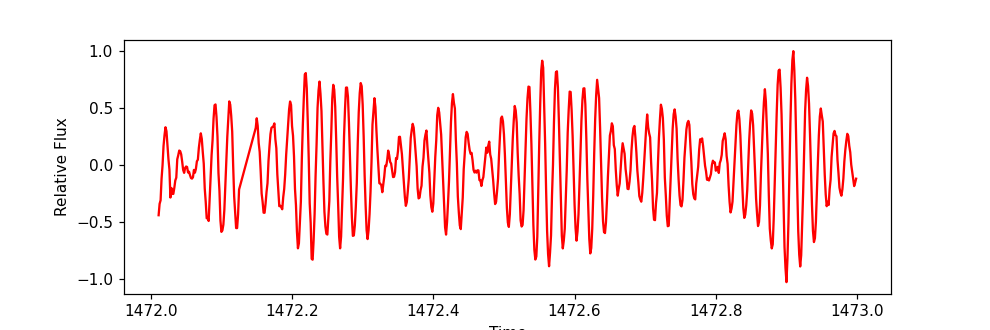

In [3]:
### TESS data import ###
data = np.loadtxt("TESS_data.dat",usecols=(0,1))
time = data[:,0][(1472<data[:,0])&(data[:,0]<1473)]
# à prendre vers 1472
#time = np.reshape(time,[32,int(62976/32)])
flux = data[:,1][(1472<data[:,0])&(data[:,0]<1473)]
#flux = np.reshape(flux,[32,int(62976/32)])
flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))

fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

In [4]:
freqs,amps,phases = np.loadtxt("TESS_freqs.txt",usecols=(1,2,3)).T
freqs_errors,amps_errors,phases_errors = np.loadtxt("TESS_freqs_errors.txt",usecols=(0,1,2)).T

In [5]:
y = []
y_error = []
for i in time:
    tmp = [] #saves one sine
    tmp_error = []
    for freq, amp, phase,freq_error,amp_error,phase_error in zip(freqs, amps, phases,freqs_errors, amps_errors, phases_errors):
#    for freq_error,amp_error,phase_error in zip(freqs_errors, amps_errors, phases_errors):
        tmp.append(amp * np.sin(2 * np.pi * freq * i + phase * 2 * np.pi))
        tmp_error.append((amp+amp_error) * np.sin(2 * np.pi * (freq+freq_error) * i + (phase+phase_error) * 2 * np.pi))
    y.append(np.sum(tmp))
    y_error.append(np.sum(tmp_error))
y = np.array(y)
flux_error = np.array(y_error)

y = (y - np.mean(y))/(np.max(y) - np.mean(y))
flux_error = (flux_error - np.mean(flux_error))/(np.max(flux_error) - np.mean(flux_error))
flux_error = y - flux_error

<IPython.core.display.Javascript object>


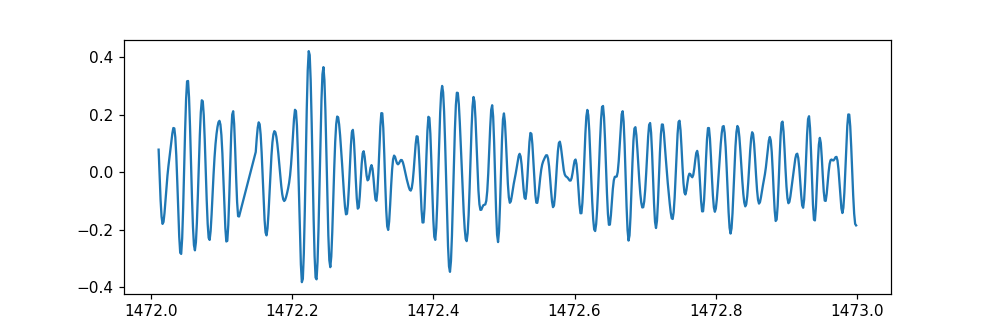

In [6]:
plt.figure(figsize=(9,3))
plt.plot(time,flux_error)
plt.show()

In [7]:
### GP Model ###
#bounds = dict(log_S0= (0,10), log_Q = (0,10), log_omega0 = (0,10))
kernel = terms.SHOTerm(log_S0=1., log_Q=1., log_omega0=5.7)

gp = celerite.GP(kernel,mean=0.0)
gp.compute(time,yerr=flux_error)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -2070.125249580517
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 1.0), ('kernel:log_omega0', 5.7)])



In [8]:
x = np.linspace(np.min(time),np.max(time),2000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


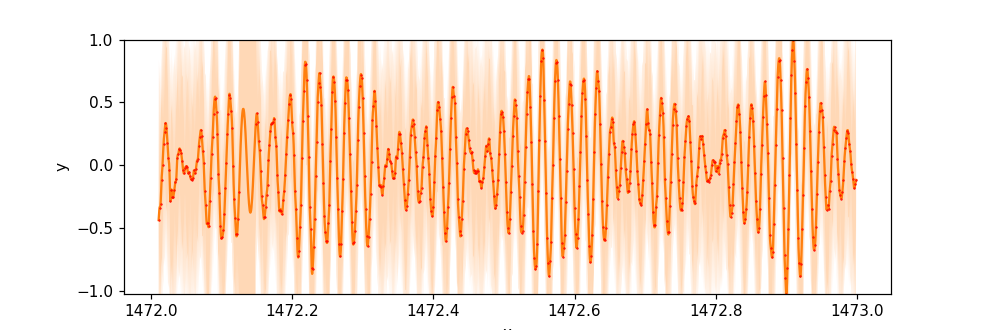

In [9]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

In [10]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
print(bounds)
# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

[(None, None), (None, None), (None, None)]
      fun: -696.4709072268968
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.05304628,  0.40422492, -0.99203135])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 456
      nit: 49
   status: 0
  success: True
        x: array([-11.31404458,   3.46419385,   5.76511061])
Final log-likelihood: 696.4709072268968
[1.22003664e-05 3.19506923e+01 3.18974323e+02]
Parameters: OrderedDict([('kernel:log_S0', -11.314044576900681), ('kernel:log_Q', 3.464193849148372), ('kernel:log_omega0', 5.765110618646955)])


In [11]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)
P = 2*np.pi/(np.exp(results.x[2])*60*24)
P

1.3679229987634918e-05

<IPython.core.display.Javascript object>


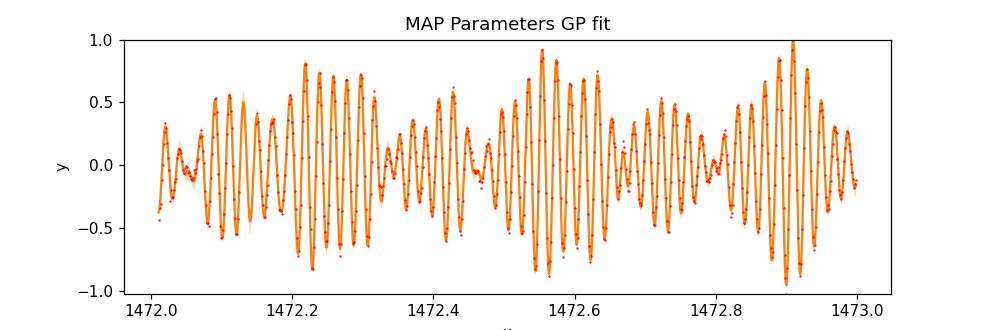

In [12]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [13]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else np.inf

In [14]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-10 < params[0] < 10) and (10 < params[1] < 10) and (-10 < params[2] < 10)) :
        return 0
    return -np.inf

In [15]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else np.inf

In [16]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000)
print("Finished")

Running burn-in...


C:\ProgramData\Anaconda3\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0


Running production...
Finished


In [17]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -11.314044576900681), ('kernel:log_Q', 3.464193849148372), ('kernel:log_omega0', 5.765110608646955)])
Final MCMC log likelihood: 696.4709072268968


<IPython.core.display.Javascript object>


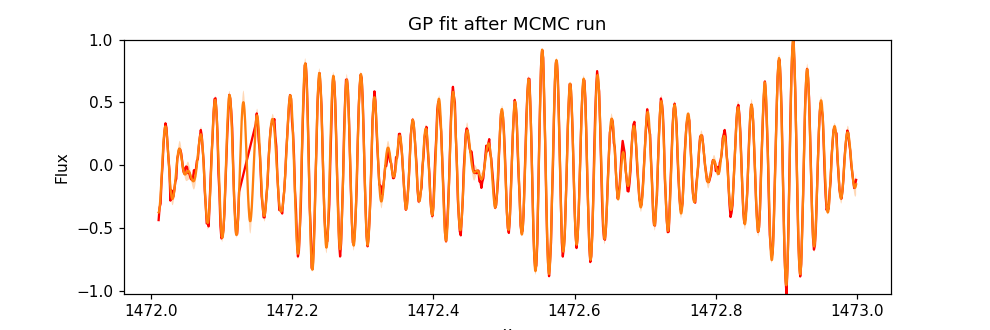

In [18]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(time,flux,c="r")
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

In [21]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[1.22003664e-05 3.19506923e+01 3.18974323e+02]


50.76634028904949

In [23]:
P = 1/f
P*24*60

28.365251302359766